# Calcul des jours Tempos

Voir : [la doc](https://www.services-rte.com/files/live/sites/services-rte/files/pdf/20160106_Methode_de_choix_des_jours_Tempo.pdf
)

## Data sources

- the ENR energy production is the one available on the RTE API "Production Forecast"
- The Total consumption is the one available on the RTE API "Consommation" also available on Eco2mix (the Excel file)
- the temperature is the observed temperature available on the meteo.data.gouv.fr website, each department has a station that provides the temperature on the Day. The Mean temperature is the average of the temperature of the 95 departments.


In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from energy_forecast import ROOT_DIR
from energy_forecast.tempo_rte import TempoPredictor


## Preparing the data

In [37]:
production_forcasted = pd.read_csv(ROOT_DIR / 'data' / 'silver' / 'forecasted_production_rte.csv', index_col=0, parse_dates=True)
production_forcasted = production_forcasted.dropna(axis=0, how="any")
production_forcasted.index = pd.to_datetime(production_forcasted.index, utc=True).tz_convert("Europe/Paris")
production_forcasted

,SOLAR_FORECAST_D1,EOLIEN_FORECAST_D1
start_date,,
2014-12-16 01:00:00+01:00,0.00,1076.00
2014-12-16 02:00:00+01:00,0.00,1045.00
2014-12-16 03:00:00+01:00,0.00,1013.00
2014-12-16 04:00:00+01:00,0.00,988.00
2014-12-16 05:00:00+01:00,0.00,963.00
...,...,...
2024-08-16 19:00:00+02:00,3058.95,1871.66
2024-08-16 20:00:00+02:00,764.46,1805.01
2024-08-16 21:00:00+02:00,1.23,1852.47


In [38]:
rte_all_data = pd.read_csv(ROOT_DIR / 'data' / 'silver' / 'rte_production.csv')[[
    'Date', 'Heures', 'Prévision J-1', 'Solaire', 'Eolien']]

index = pd.to_datetime(rte_all_data['Date'] + ' ' + rte_all_data['Heures'].astype(str) + ':00')
rte_all_data.index = index.dt.tz_localize('UTC').dt.tz_convert('Europe/Paris')
rte_all_data = rte_all_data.drop(columns=['Date', 'Heures'])
rte_all_data = rte_all_data.dropna(axis=0, how='any')
rte_all_data = rte_all_data.astype(float)
rte_all_data = rte_all_data.resample('1h').mean()

/tmp/ipykernel_4968/3459037049.py:1: DtypeWarning: Columns (5,18,19,20,21,22,26,27,30,31,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  rte_all_data = pd.read_csv(ROOT_DIR / 'data' / 'silver' / 'rte_production.csv')[[


In [39]:
rte_all_data

,Prévision J-1,Solaire,Eolien
2014-01-01 01:00:00+01:00,62650.0,0.00,3413.00
2014-01-01 02:00:00+01:00,60250.0,0.00,3291.50
2014-01-01 03:00:00+01:00,59400.0,0.00,3275.50
2014-01-01 04:00:00+01:00,55700.0,0.00,3258.00
2014-01-01 05:00:00+01:00,52650.0,0.00,3398.00
...,...,...,...
2024-04-08 11:00:00+02:00,51450.0,3026.00,4151.75
2024-04-08 12:00:00+02:00,51350.0,5092.75,4282.25
2024-04-08 13:00:00+02:00,51362.5,7110.25,5120.50
2024-04-08 14:00:00+02:00,51537.5,8841.50,6496.25


In [6]:
daily_production = rte_all_data.resample('1d').sum()
daily_production


,Prévision J-1,Solaire,Eolien
2014-01-01 00:00:00+01:00,1274250.0,4776.00,114472.50
2014-01-02 00:00:00+01:00,1436150.0,4871.50,110732.50
2014-01-03 00:00:00+01:00,1449150.0,3257.50,132188.50
2014-01-04 00:00:00+01:00,1384600.0,2870.50,99399.00
2014-01-05 00:00:00+01:00,1402900.0,5765.50,82688.00
...,...,...,...
2024-04-04 00:00:00+02:00,1173500.0,76644.50,290434.00
2024-04-05 00:00:00+02:00,1125362.5,72310.50,230215.75
2024-04-06 00:00:00+02:00,967137.5,61951.00,224055.00
2024-04-07 00:00:00+02:00,928362.5,46914.00,146855.00


In [40]:
tempos = pd.read_csv(ROOT_DIR / 'data' / 'silver' / 'tempo_2014_2024.csv', index_col=0, parse_dates=True)
tempos.index = tempos.index.tz_localize("Europe/Paris")
tempos

,tempo_type
Date,
2014-09-01 00:00:00+02:00,BLEU
2014-09-02 00:00:00+02:00,BLEU
2014-09-03 00:00:00+02:00,BLEU
2014-09-04 00:00:00+02:00,BLEU
2014-09-05 00:00:00+02:00,BLEU
...,...
2024-06-20 00:00:00+02:00,BLEU
2024-06-21 00:00:00+02:00,BLEU
2024-06-22 00:00:00+02:00,BLEU


## Concatenate the needed collumns

In [41]:
# average from 6am
origin = rte_all_data.index[0] + pd.DateOffset(hour=6, minute=0)
daily_consumption = rte_all_data["Prévision J-1"].resample("1D", origin=origin).sum()
daily_consumption.index = daily_consumption.index + pd.DateOffset(hour=0)
daily_consumption

/tmp/ipykernel_4968/2617323631.py:4: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  daily_consumption.index = daily_consumption.index + pd.DateOffset(hour=0)


2013-12-31 00:00:00+01:00     290650.0
2014-01-01 00:00:00+01:00    1301750.0
2014-01-02 00:00:00+01:00    1455200.0
2014-01-03 00:00:00+01:00    1446300.0
2014-01-04 00:00:00+01:00    1393550.0
                               ...    
2024-04-04 00:00:00+02:00    1163350.0
2024-04-05 00:00:00+02:00    1110187.5
2024-04-06 00:00:00+02:00     950700.0
2024-04-07 00:00:00+02:00     930150.0
2024-04-08 00:00:00+02:00     468475.0
Name: Prévision J-1, Length: 3752, dtype: float64

In [42]:
origin = production_forcasted.index[0]+ pd.DateOffset(hour=6, minute=0)
daily_production = production_forcasted.resample("1D", origin=origin).sum()
daily_production.index = daily_production.index + pd.DateOffset(hour=0)
daily_production.rename(columns={"SOLAR_FORECAST_D1": "Solaire", "EOLIEN_FORECAST_D1": "Eolien"}, inplace=True)
daily_production

/tmp/ipykernel_4968/994817580.py:3: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  daily_production.index = daily_production.index + pd.DateOffset(hour=0)


,Solaire,Eolien
start_date,,
2014-12-15 00:00:00+01:00,0.00,5085.00
2014-12-16 00:00:00+01:00,4870.89,39909.00
2014-12-17 00:00:00+01:00,4609.62,103617.00
2014-12-18 00:00:00+01:00,5258.76,122720.00
2014-12-19 00:00:00+01:00,6289.70,104494.00
...,...,...
2024-08-12 00:00:00+02:00,116114.62,67128.44
2024-08-13 00:00:00+02:00,96650.51,36417.80
2024-08-14 00:00:00+02:00,74620.37,43453.81


In [44]:
daily_production["Prévision J-1"] = daily_consumption
daily_production["Production_nette"] = daily_production["Prévision J-1"] - (
    daily_production["Solaire"] + daily_production["Eolien"]
    )

In [45]:
quantils = daily_production["Production_nette"].rolling(365, center=False).aggregate({"q40": lambda x: x.quantile(0.4),
                                                                           "q80": lambda x: x.quantile(0.8)}).bfill()
daily_production["Production_nette_q40"] = quantils["q40"]
daily_production["Production_nette_q80"] = quantils["q80"]

# historical weather

In [46]:
from energy_forecast.meteo import aggregates_observations, download_observations_all_departments

all_dep_filenames_2022 = download_observations_all_departments()
all_dep_mean_temperature_2022 = aggregates_observations(all_dep_filenames_2022)

In [47]:
all_dep_mean_temperature_2022

AAAAMMJJ
2023-01-01    12.163991
2023-01-02     9.506840
2023-01-03     7.085597
2023-01-04     8.494031
2023-01-05     9.781422
                ...    
2024-09-12    10.936362
2024-09-13    10.629364
2024-09-14    11.353159
2024-09-15    12.184974
2024-09-16    13.959155
Length: 625, dtype: float64

In [24]:
all_dep_filenames_1950 = download_observations_all_departments(cache_duration="1200h",
                                                               file_type="previous-1950-2022_RR-T-Vent",
                                                               verbose=True,
                                                               )

In [25]:
all_dep_mean_temperature_2013 = aggregates_observations(all_dep_filenames_1950, cut_before="2013-09-01", verbose=True)

INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress-production/data/bronze/observations/Q_01_previous-1950-2022_RR-T-Vent.csv.gz (1/95)


INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress-production/data/bronze/observations/Q_02_previous-1950-2022_RR-T-Vent.csv.gz (2/95)
INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress-production/data/bronze/observations/Q_03_previous-1950-2022_RR-T-Vent.csv.gz (3/95)
INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress-production/data/bronze/observations/Q_04_previous-1950-2022_RR-T-Vent.csv.gz (4/95)
INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress-production/data/bronze/observations/Q_05_previous-1950-2022_RR-T-Vent.csv.gz (5/95)
INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress-production/data/bronze/observations/Q_06_previous-1950-2022_RR-T-Vent.csv.gz (6/95)
INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress-production/data/bronze/observations/Q_07_previous-1950-2022_RR-T-Vent.csv.gz (7/95)
INFO:energy_forecast.meteo:Reading /home/antoine/code/energetic-stress

In [26]:
from energy_forecast import ROOT_DIR
all_dep_mean_temperature_2013.to_csv(ROOT_DIR / 'data' / 'silver' / 'all_dep_mean_temperature_2013.csv')

In [27]:
# Reload

In [31]:
all_dep_mean_temperature_2013 = pd.read_csv(ROOT_DIR / 'data' / 'silver' / 'all_dep_mean_temperature_2013.csv', index_col=0, parse_dates=True)

In [51]:
all_dep_mean_temperature_2013

,0
AAAAMMJJ,
2013-09-01,16.312595
2013-09-02,16.497312
2013-09-03,18.602833
2013-09-04,20.945904
2013-09-05,21.346506
...,...
2022-12-27,6.259121
2022-12-28,8.497527
2022-12-29,8.885538


In [58]:
all_dep_mean_temperature = pd.concat([all_dep_mean_temperature_2013.loc[:, "0"],
                                      all_dep_mean_temperature_2022], axis=0)
all_dep_mean_temperature.sort_index(inplace=True)

<Axes: xlabel='AAAAMMJJ'>

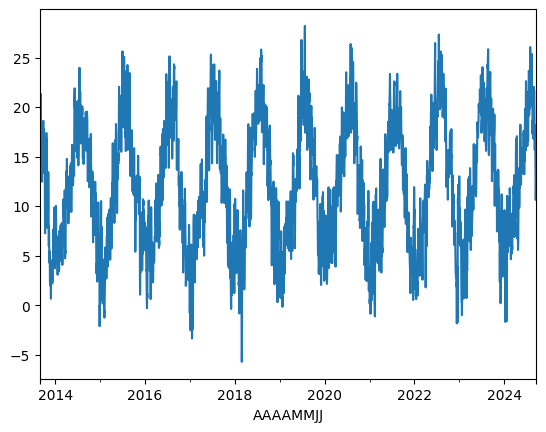

In [62]:
all_dep_mean_temperature.plot()

In [63]:
mean_temperature_q30 = all_dep_mean_temperature.rolling(365, center=False).aggregate(lambda x: x.quantile(0.3)).bfill()


<Axes: xlabel='AAAAMMJJ'>

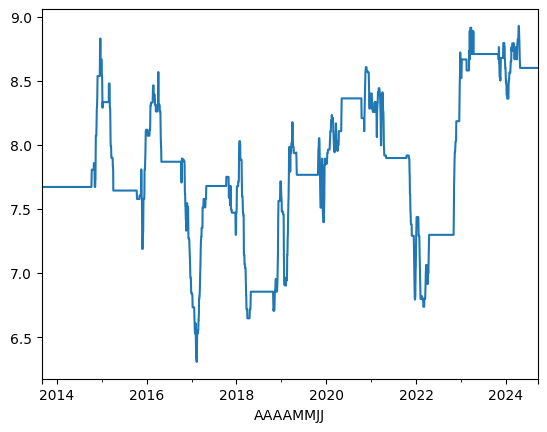

In [64]:
mean_temperature_q30.plot()

In [72]:
daily_consumption_naive_tz = daily_consumption.tz_localize(None)
daily_production_naive_tz = daily_production.tz_localize(None)
tempos_naive_tz = tempos.tz_localize(None)
daily_production_naive_tz["Mean_temp_q30"] = mean_temperature_q30


In [73]:
daily_production_naive_tz

,Solaire,Eolien,Prévision J-1,nette,Production_nette,Production_nette_q40,Production_nette_q80,Mean_temp_q30
start_date,,,,,,,,
2014-12-15,0.00,5085.00,1643500.0,1638415.00,1638415.00,1103302.956,1476113.766,8.537848
2014-12-16,4870.89,39909.00,1643650.0,1598870.11,1598870.11,1103302.956,1476113.766,8.537848
2014-12-17,4609.62,103617.00,1584100.0,1475873.38,1475873.38,1103302.956,1476113.766,8.537848
2014-12-18,5258.76,122720.00,1494350.0,1366371.24,1366371.24,1103302.956,1476113.766,8.666227
2014-12-19,6289.70,104494.00,1449000.0,1338216.30,1338216.30,1103302.956,1476113.766,8.829757
...,...,...,...,...,...,...,...,...
2024-08-12,116114.62,67128.44,NaN,NaN,NaN,NaN,NaN,8.601025
2024-08-13,96650.51,36417.80,NaN,NaN,NaN,NaN,NaN,8.601025
2024-08-14,74620.37,43453.81,NaN,NaN,NaN,NaN,NaN,8.601025


In [74]:

data = pd.concat([daily_consumption_naive_tz, daily_production_naive_tz, tempos_naive_tz],
                 axis=1).sort_index().dropna(axis=0, how="any")

data = data[~data.index.duplicated()]
year = data.index[0].year
first_september = data.index[0] + pd.DateOffset(month=9, day=1, year=year)
if first_september < data.index[0]:
    first_september += pd.DateOffset(years=1)

last_august = data.index[-1] - pd.DateOffset(month=8, day=31)
data.rename(columns={
    "Prévision J-1": "Prévision_J-1",
    "SOLAR_FORECAST_D1":"Solaire",
    "EOLIEN_FORECAST_D1":"Eolien",
    "tempo_type":"Type_de_jour_TEMPO",
}, inplace=True)

data[first_september: last_august]


,Prévision_J-1,Solaire,Eolien,Prévision_J-1,nette,Production_nette,Production_nette_q40,Production_nette_q80,Mean_temp_q30,Type_de_jour_TEMPO
2015-09-01,1167400.0,21617.70,30097.00,1167400.0,1115685.30,1115685.30,1103302.956,1476113.766,7.644259,BLEU
2015-09-02,1137500.0,24844.99,18895.00,1137500.0,1093760.01,1093760.01,1103302.956,1476113.766,7.644259,BLEU
2015-09-03,1127150.0,21967.80,24162.00,1127150.0,1081020.20,1081020.20,1103302.956,1476113.766,7.644259,BLEU
2015-09-04,1117350.0,25466.61,24709.00,1117350.0,1067174.39,1067174.39,1103302.956,1476113.766,7.644259,BLEU
2015-09-05,980050.0,27009.82,32334.00,980050.0,920706.18,920706.18,1103302.956,1476113.766,7.644259,BLEU
...,...,...,...,...,...,...,...,...,...,...
2024-04-04,1163350.0,62687.02,279577.48,1163350.0,821085.50,821085.50,871976.352,1132033.542,8.796117,BLEU
2024-04-05,1110187.5,71763.38,175006.34,1110187.5,863417.78,863417.78,871826.910,1132033.542,8.800151,BLEU
2024-04-06,950700.0,0.00,0.00,950700.0,950700.00,950700.00,871826.910,1132033.542,8.826117,BLEU
2024-04-07,930150.0,0.00,0.00,930150.0,930150.00,930150.00,871826.910,1132033.542,8.826117,BLEU


In [76]:
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")
predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2014


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,40,0,3
BLEU,4,297,0
ROUGE,1,0,21


In [77]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2016/2016


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,17,1,25
BLEU,10,287,3
ROUGE,0,4,18


In [78]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2017/2018


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,24,2,17
BLEU,16,282,2
ROUGE,0,0,22


In [79]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2018/2019


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,30,0,13
BLEU,8,292,0
ROUGE,0,2,20


In [80]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2019/2020


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,28,9,10
BLEU,8,292,1
ROUGE,1,0,17


In [81]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2020/2021


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,37,1,5
BLEU,7,293,0
ROUGE,0,0,22


In [82]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2021/2022


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,32,1,9
BLEU,84,217,0
ROUGE,0,0,22


In [83]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2022/2023


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,31,2,10
BLEU,5,295,0
ROUGE,0,0,22


In [84]:
first_september = second_septembre
second_septembre = first_september + pd.DateOffset(years=1)
data_first_year = data[first_september: second_septembre - pd.DateOffset(days=1) ].copy()
predictor = TempoPredictor(data_first_year)
predictions = predictor.predict()
print(f"Analyse de l'année {first_september.year}/{second_septembre.year}")

predictor.confusion_matrix(data_pred=predictions)

Analyse de l'année 2023/2024


col_0,prediction_blanc,prediction_bleu,prediction_rouge
Type_de_jour_TEMPO,,,
BLANC,29,2,4
BLEU,7,157,0
ROUGE,0,1,21


In [86]:
import matplotlib.pyplot as plt
import numpy as np

In [87]:
predictor.categories["ROUGE"]

2023-09-01    0
2023-09-02    0
2023-09-03    0
2023-09-04    0
2023-09-05    0
             ..
2024-04-04    0
2024-04-05    0
2024-04-06    0
2024-04-07    0
2024-04-08    0
Freq: D, Name: ROUGE, Length: 221, dtype: int64

Text(0.5, 1.0, 'Production normée et seuils de déclenchement des couleurs Tempo')

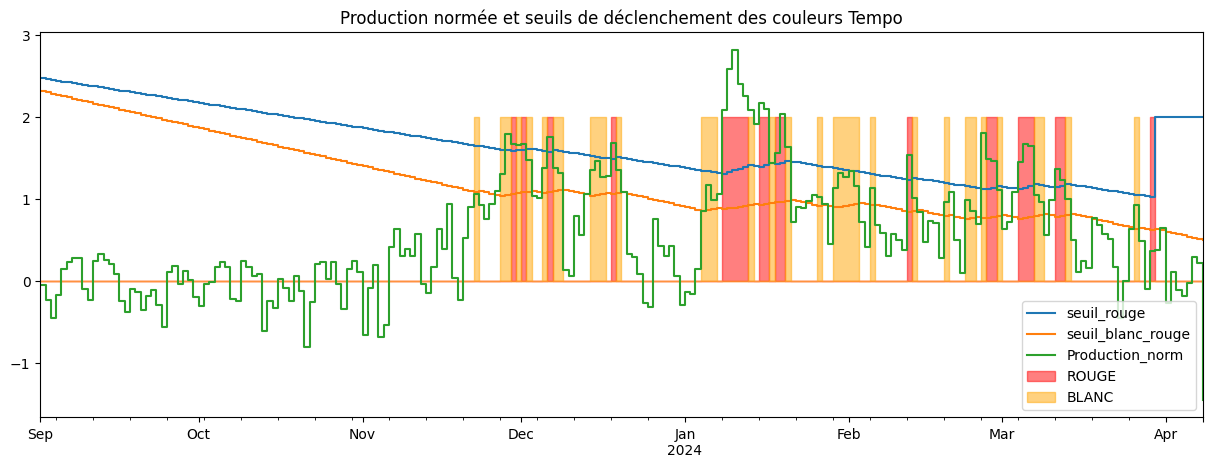

In [88]:
ax = predictor.data[["seuil_rouge", "seuil_blanc_rouge", "Production_norm"]].plot(
    drawstyle="steps-post", figsize=(15, 5)
)

xs = np.arange(ax.dataLim.min[0], ax.dataLim.max[0] + 1, 1)
ax.fill_between(
    xs,
    predictor.categories["ROUGE"].values * 2,
    step="post",
    color="red",
    alpha=0.5,
    label="ROUGE",
)
# predictor.categories["ROUGE"].plot(ax=ax, style="-", color="red", drawstyle="steps-post")
ax.fill_between(
    xs,
    predictor.categories["BLANC"].values * 2,
    step="post",
    color="orange",
    alpha=0.5,
    label="BLANC",
)
# predictor.categories["BLANC"].plot(ax=ax, style="-", color="orange", drawstyle="steps-post")
ax.legend()
ax.set_title("Production normée et seuils de déclenchement des couleurs Tempo")

Text(0.5, 1.0, 'Production normée et seuils de déclenchement des couleurs Tempo')

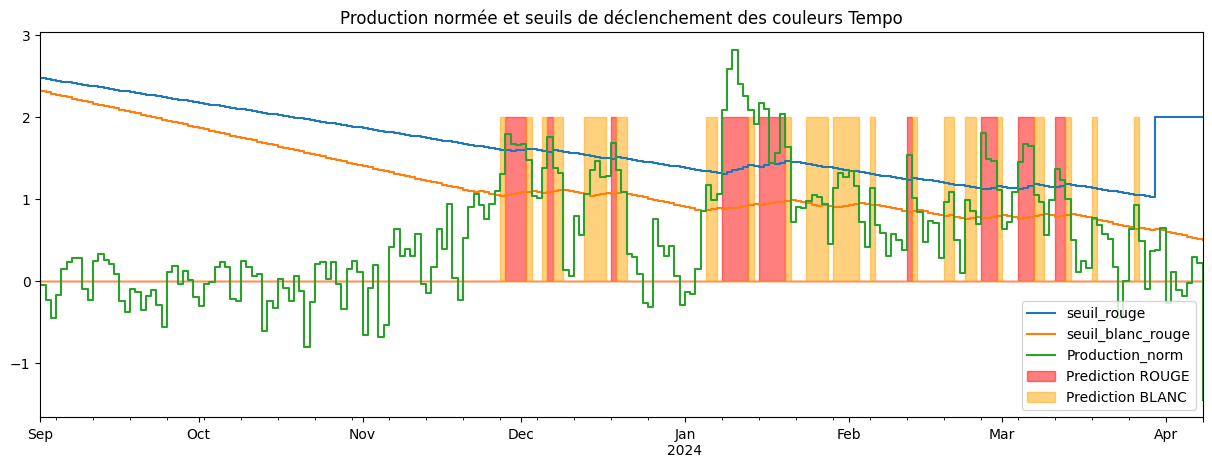

In [90]:
predictions = predictor.predict()
predictions["prediction_rouge"].astype(int).plot(
    ax=ax, style="-", color="red", drawstyle="steps-post"
)
predictions["prediction_blanc"].astype(int).plot(
    ax=ax, style="-", color="orange", drawstyle="steps-post"
)

ax = predictor.data[["seuil_rouge", "seuil_blanc_rouge", "Production_norm"]].plot(
    drawstyle="steps-post", figsize=(15, 5)
)

xs = np.arange(ax.dataLim.min[0], ax.dataLim.max[0] + 1, 1)
ax.fill_between(
    xs,
    predictions["prediction_rouge"].values * 2,
    step="post",
    color="red",
    alpha=0.5,
    label="Prediction ROUGE",
)
# predictor.categories["ROUGE"].plot(ax=ax, style="-", color="red", drawstyle="steps-post")
ax.fill_between(
    xs,
    predictions["prediction_blanc"].values * 2,
    step="post",
    color="orange",
    alpha=0.5,
    label="Prediction BLANC",
)
# predictor.categories["BLANC"].plot(ax=ax, style="-", color="orange", drawstyle="steps-post")
ax.legend()
ax.set_title("Production normée et seuils de déclenchement des couleurs Tempo")